In [223]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [224]:
all_feature_df = pd.read_csv("all_features.csv")
all_feature = {col: all_feature_df[col].values for col in all_feature_df.columns}



features_BKG_df = all_feature_df[all_feature_df['Label'] == 0] #Qui c'è sia IBD_fake che BKG_radioactive
features_BKG = {col: features_BKG_df[col].values for col in features_BKG_df.columns}

features_IBD_df = all_feature_df[all_feature_df['Label'] == 1] #Label = 1 sono i VERI ibd
features_IBD = {col: features_IBD_df[col].values for col in features_IBD_df.columns}


In [225]:
print(features_BKG["Label"].shape)
print(features_IBD["Label"].shape)

(1000081,)
(1468385,)


# Cutting algorithm for BOTH IBD and BKG

Balancing Datsets

In [226]:
from numba import njit, prange

In [227]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: 
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

### IBD selection, searching for true IBD events

In [229]:
# prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
#                                                                            features_IBD["delta_radius"],
#                                                                            features_IBD["E_pro"],
#                                                                            features_IBD["E_del"])

In [230]:
# print("False BKG ",  prompt_columns_IBD.shape[0] - prompt_columns_IBD.sum(),"Su un tot di", prompt_columns_IBD.shape[0])


# TP = np.logical_and(features_IBD['Label'] == 1, prompt_columns_IBD == 1)
# TN = np.logical_and(features_IBD['Label'] == 0, prompt_columns_IBD == 0)
# FN = np.logical_and(features_IBD["Label"] == 1, prompt_columns_IBD == 0)
# FP = np.logical_and(features_IBD["Label"] == 0, prompt_columns_IBD == 1) 

# print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)

# #Efficiency sono il numero di eventi IBD veri selezionati diviso il numero totale di IBD.
# print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

### BKG selection, searching for fake IBD eventi in BKG_RADIOACTIVITY dataset

In [231]:
# prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"][features_BKG["Source"] == 0],
#                                                                            features_BKG["delta_radius"][features_BKG["Source"] == 0],
#                                                                            features_BKG["E_pro"][features_BKG["Source"] == 0],
#                                                                            features_BKG["E_del"][features_BKG["Source"] == 0])

In [232]:
# print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])
# print("H: ", delay_columns_BKG.sum(),delay_columns_BKG.shape[0])
# print("C: ", delay_columns_carb_BKG.sum(),delay_columns_carb_BKG.shape[0])

# TP = np.logical_and(features_BKG['Label'][features_BKG["Source"] == 0] == 0, prompt_columns_BKG == 0)
# TN = np.logical_and(features_BKG['Label'][features_BKG["Source"] == 0] == 1, prompt_columns_BKG == 1)
# FN = np.logical_and(features_BKG["Label"][features_BKG["Source"] == 0] == 0, prompt_columns_BKG == 1)
# FP = np.logical_and(features_BKG["Label"][features_BKG["Source"] == 0] == 1, prompt_columns_BKG == 0) 


# print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
# print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

# TOTAL Cut Algorithm 

In [233]:
all_feature = pd.DataFrame.from_dict(all_feature)


In [234]:
# Elimina gli elementi desiderati dal dataset
num_IBD = all_feature["delta_time"][all_feature['Label']==1].shape[0]
num_BKG = all_feature["delta_time"][all_feature['Label']==0].shape[0]

del_BKG = 0
del_IBD = 0

if num_IBD > num_BKG:
    del_IBD = num_IBD - num_BKG
    to_del_ibd = all_feature.shape[0] - del_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[:to_del_ibd]

elif num_IBD < num_BKG:
    del_BKG = num_BKG - num_IBD
    order = np.argsort(all_feature["Label"])
    all_feature = all_feature.iloc[order].dropna()
    all_feature = all_feature.iloc[del_BKG:]

print("BKG:", all_feature["Label"][all_feature['Label']==0].shape[0]) 
print("IBD:",  all_feature["Label"][all_feature['Label']==1].shape[0])

BKG: 1000081
IBD: 1000081


In [235]:
from sklearn.model_selection import train_test_split


columns_to_exclude = ['Label', 'Source']


X = all_feature.drop(columns_to_exclude, axis=1)
Y = all_feature['Label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.1)

In [236]:
X_test = X_test.to_records(index=False)

In [237]:
X_test

rec.array([(5.14169   ,   424.19466121, 2.21325   , 14521.48227905,  19920., 14849.23811265),
           (0.14921181,  4678.61523438, 0.23275365, 10539.63671875, 296194., 13831.72265625),
           (0.17624289, 14850.32128906, 0.62020612, 11054.87011719, 982043.,  9920.59960938),
           ...,
           (5.68778   ,   549.66431356, 2.29578   , 12123.44803926,  10576., 12502.79793434),
           (3.3047    ,   125.07715739, 2.26651   , 13220.91570242, 155600., 13315.21846807),
           (2.46898   ,   168.05786801, 2.21297   , 16448.89907905,  66912., 16549.11677413)],
          dtype=[('E_pro', '<f8'), ('delta_radius', '<f8'), ('E_del', '<f8'), ('R_delayed', '<f8'), ('delta_time', '<f8'), ('R_prompt', '<f8')])

In [238]:
prompt_columns, delay_columns, delay_columns_carb = selection(X_test["delta_time"],
                                                              X_test["delta_radius"],
                                                              X_test["E_pro"],
                                                              X_test["E_del"])

In [251]:
TP = np.logical_and(y_test == 1, prompt_columns == 1)
TN = np.logical_and(y_test == 0, prompt_columns == 0)
FN = np.logical_and(y_test == 1, prompt_columns == 0)
FP = np.logical_and(y_test == 0, prompt_columns == 1) 

import sklearn

print("Efficiency IBD: ", (TP.sum()/(TP.sum()+FN.sum())))
print("Efficiency BKG: ", (TN.sum()/(TN.sum()+FP.sum())))

sklearn.metrics.confusion_matrix(y_test, prompt_columns)

Efficiency IBD:  0.9770288355028044
Efficiency BKG:  0.9999750650801408


array([[200517,      5],
       [  4583, 194928]])

In [ ]:
import sklearn
import torch.nn.functional as nnf

input_tensor = torch.tensor(X_test_normed, dtype=torch.float32).to('cpu')

y_pred = net(torch.from_numpy(X_test_normed).float().cpu())#,  dtype = torch.float32)

probs = net(input_tensor).to('cpu')
probs_normed = nnf.softmax(probs, dim=1).to('cpu')
p_, y_pred = probs_normed.topk(1, dim = 1)


print(sklearn.metrics.classification_report(y_test, y_pred))
sklearn.metrics.confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    200277
         1.0       1.00      1.00      1.00    199756

    accuracy                           1.00    400033
   macro avg       1.00      1.00      1.00    400033
weighted avg       1.00      1.00      1.00    400033



array([[200231,     46],
       [    30, 199726]])

# Plots

Delta_time and Delta_radius

In [ ]:

dataset = pd.concat([pd.DataFrame.from_dict(features_BKG), pd.DataFrame.from_dict(features_IBD)])

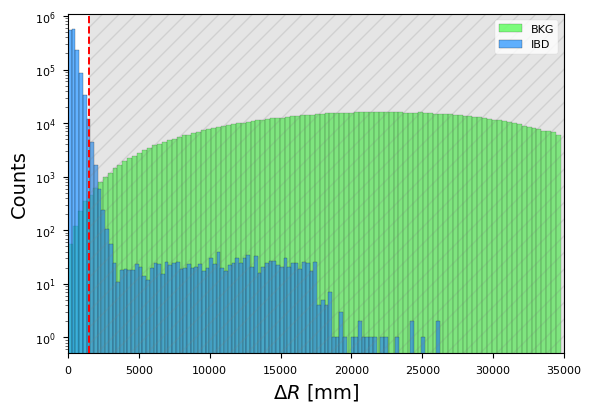

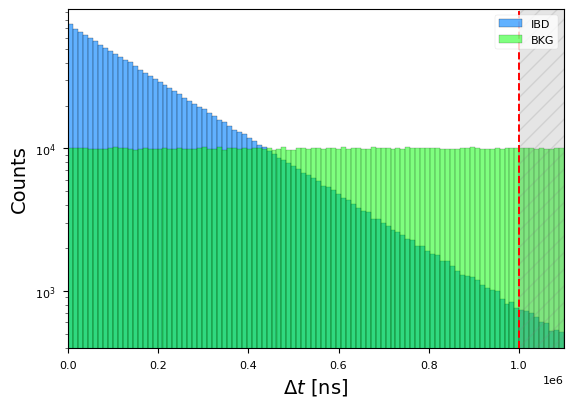

In [ ]:

delta_radius_cut = 1500

fig2 = plt.figure()

plt.hist(all_feature["delta_radius"][all_feature['Label'] == 0], bins=100, color='lime', alpha=0.5, label='BKG', log=True)
plt.hist(all_feature["delta_radius"][all_feature['Label'] == 1], bins=100, color='dodgerblue', alpha=0.7, label='IBD', log=True)

plt.axvline(delta_radius_cut, ls='--', c='red')
plt.axvspan(delta_radius_cut,35000, alpha=0.2, color='gray', hatch='//')

plt.xlim(0, 35000)
plt.xlabel(r'$\Delta R$ [mm]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(loc='upper right')

plt.savefig('../../../../Latex/Images/Cut/delta_radius.png')
plt.show()

#--------------------------------------------------

delta_time_cut = 1e6
fig2 = plt.figure()


plt.hist(all_feature['delta_time'][all_feature['Label'] == 1],bins=100, color='dodgerblue',alpha = 0.7, label='IBD', log = 'True')
plt.hist(all_feature['delta_time'][all_feature['Label'] == 0],bins=100, color='lime',alpha = 0.5, label='BKG', log = 'True')

plt.axvline(delta_time_cut, ls = '--', c = 'red')
plt.axvspan(delta_time_cut, 5*220e3, alpha=0.2, color='gray', hatch='//')

plt.xlim(0,5*220e3)
plt.xlabel(r'$\Delta t}$ [ns]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(loc='upper right')

plt.savefig('../../../../Latex/Images/Cut/delta_time.png')

plt.show()



E_pro

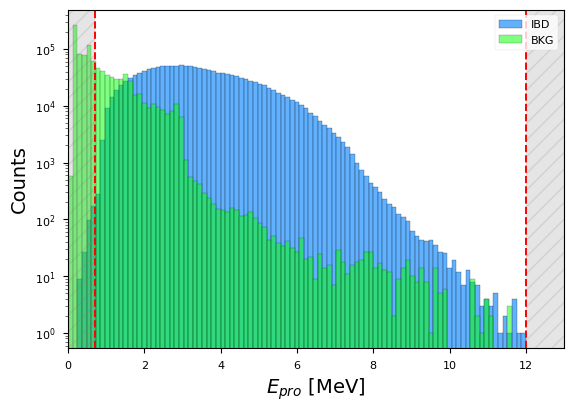

In [ ]:
E_pro_cut_1_min = 0.7
E_pro_cut_1_max = 12


fig2 = plt.figure()

plt.hist(all_feature['E_pro'][all_feature['Label'] == 1],np.linspace(0,12,100),color='dodgerblue',alpha = 0.7, label='IBD', log = 'True')
plt.hist(all_feature['E_pro'][all_feature['Label'] == 0],np.linspace(0,12,100), color='lime',alpha = 0.5, label='BKG', log = 'True')
plt.xlim(0,13)

plt.axvline(E_pro_cut_1_min, ls = '--', c = 'red')
plt.axvline(E_pro_cut_1_max, ls = '--', c = 'red')




plt.axvspan(0,E_pro_cut_1_min, alpha=0.2, color='gray', hatch='//')
plt.axvspan(E_pro_cut_1_max, 13, alpha=0.2, color='gray', hatch='//')


plt.xlabel(r'$E_{pro}$ [MeV]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(loc='upper right')


plt.savefig('../../../../Latex/Images/Cut/e_pro.png')
plt.show()

E_del

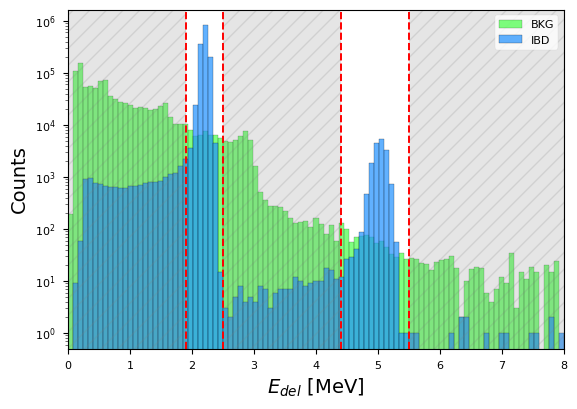

In [ ]:
E_del_cut_1_min = 1.9
E_del_cut_1_max = 2.5

E_del_cut_2_min = 4.4
E_del_cut_2_max = 5.5

fig2 = plt.figure()
plt.hist(all_feature['E_del'][all_feature['Label'] == 0],np.linspace(0,8,100), color='lime',alpha = 0.5, label='BKG', log = 'True')
plt.hist(all_feature['E_del'][all_feature['Label'] == 1],np.linspace(0,8,100), color='dodgerblue',alpha = 0.7, label='IBD', log = 'True')
plt.xlim(0,8)

plt.axvline(E_del_cut_1_min, ls = '--', c = 'red')
plt.axvline(E_del_cut_1_max, ls = '--', c = 'red')

plt.axvline(E_del_cut_2_min, ls = '--', c = 'red')
plt.axvline(E_del_cut_2_max, ls = '--', c = 'red')


plt.axvspan(0,E_del_cut_1_min, alpha=0.2, color='gray', hatch='//')
plt.axvspan(E_del_cut_1_max, E_del_cut_2_min, alpha=0.2, color='gray', hatch='//')
plt.axvspan(E_del_cut_2_max, 8, alpha=0.2, color='gray', hatch='//')


plt.xlabel(r'$E_{del}$ [MeV]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend()

plt.savefig('../../../../Latex/Images/Cut/e_del.png')
plt.show()
